In [ ]:
import pandas as pd
import numpy as np

# we use this 5 videos for testing

In [ ]:
df = pd.read_csv('/content/VolumeTracings.csv')
#using 5 selected videos i chose (replace with whatever 5 videos you have downloaded)
filenames = ['0XFDFBA5702E94ABF.avi', '0XFDFD17B7CCFE5AF.avi', '0XFE6E32991136338.avi', '0XFE83FF3D3B13C3A.avi', '0XFEBEEFF93F6FEB9.avi']
filtered_df = df[df['FileName'].isin(filenames)]

In [ ]:
distinct_frames_by_filename = filtered_df.groupby('FileName')['Frame'].apply(lambda x: x.unique())

In [ ]:
import cv2
import os


video_paths = [
    '/content/0XFDFBA5702E94ABF.avi',
    '/content/0XFDFD17B7CCFE5AF.avi',
    '/content/0XFE6E32991136338.avi',
    '/content/0XFE83FF3D3B13C3A.avi',
    '/content/0XFEBEEFF93F6FEB9.avi',
]

frame_numbers_per_video = [
    [100, 117],
    [66, 85],
    [31, 45],
    [49, 67],
    [25, 38],
]

current_frame_numbers = [0] * len(video_paths)

output_directory = 'all_frames'
os.makedirs(output_directory, exist_ok=True)

for video_path, target_frame_numbers in zip(video_paths, frame_numbers_per_video):
    cap = cv2.VideoCapture(video_path)

    while True:
        ret, frame = cap.read()

        if not ret or current_frame_numbers[video_paths.index(video_path)] in target_frame_numbers:
            if current_frame_numbers[video_paths.index(video_path)] in target_frame_numbers:
                output_file = os.path.join(output_directory, f'frame_{current_frame_numbers[video_paths.index(video_path)]}.jpg')
                cv2.imwrite(output_file, frame)
                print(f"Saved frame {current_frame_numbers[video_paths.index(video_path)]} from {video_path} as {output_file}")
                target_frame_numbers.remove(current_frame_numbers[video_paths.index(video_path)])

            if not target_frame_numbers:
                break

        current_frame_numbers[video_paths.index(video_path)] += 1


    cap.release()

print("All frames have been saved to the common directory.")


Saved frame 100 from /content/0XFDFBA5702E94ABF.avi as all_frames/frame_100.jpg
Saved frame 117 from /content/0XFDFBA5702E94ABF.avi as all_frames/frame_117.jpg
Saved frame 66 from /content/0XFDFD17B7CCFE5AF.avi as all_frames/frame_66.jpg
Saved frame 85 from /content/0XFDFD17B7CCFE5AF.avi as all_frames/frame_85.jpg
Saved frame 31 from /content/0XFE6E32991136338.avi as all_frames/frame_31.jpg
Saved frame 45 from /content/0XFE6E32991136338.avi as all_frames/frame_45.jpg
Saved frame 49 from /content/0XFE83FF3D3B13C3A.avi as all_frames/frame_49.jpg
Saved frame 67 from /content/0XFE83FF3D3B13C3A.avi as all_frames/frame_67.jpg
Saved frame 25 from /content/0XFEBEEFF93F6FEB9.avi as all_frames/frame_25.jpg
Saved frame 38 from /content/0XFEBEEFF93F6FEB9.avi as all_frames/frame_38.jpg
All frames have been saved to the common directory.


# we order the points ( we first calculate the centroid, then we order the points clockwise using the centroid as reference, then we use refined_sort to correct the order of certain points based on distance)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_centroid(points):
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    centroid_x = sum(x) / len(points)
    centroid_y = sum(y) / len(points)
    return centroid_x, centroid_y

def sort_points_clockwise(points):
    centroid_x, centroid_y = calculate_centroid(points)
    return sorted(points, key=lambda p: (np.arctan2(p[1] - centroid_y, p[0] - centroid_x), p[0]))


def refined_sort(points):
    sorted_points_angle = sort_points_clockwise(points)

    refined_points = [sorted_points_angle[0]]
    for i in range(1, len(sorted_points_angle)-1):
        current_point = sorted_points_angle[i]

        distances = [(np.linalg.norm(np.array(current_point) - np.array(sorted_points_angle[j])), j)
                     for j in range(i-1, min(i+2, len(sorted_points_angle)))]

        distances.sort(key=lambda x: x[0])

        refined_points.append(sorted_points_angle[distances[0][1]])

    refined_points.append(sorted_points_angle[-1])

    return refined_points

from scipy.spatial import distance

# after ordering the points we connect them and creat the masks and the contours

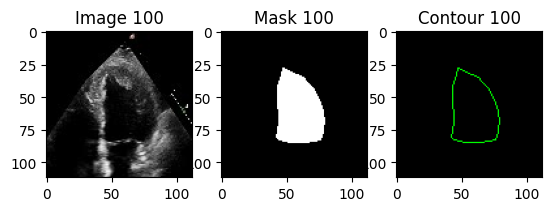

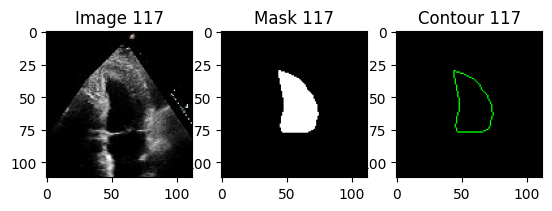

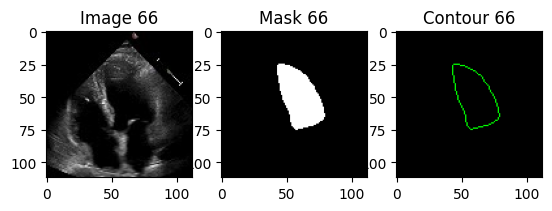

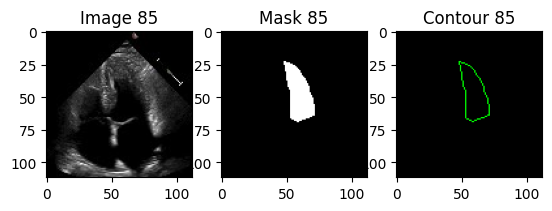

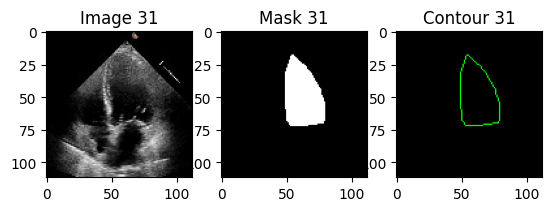

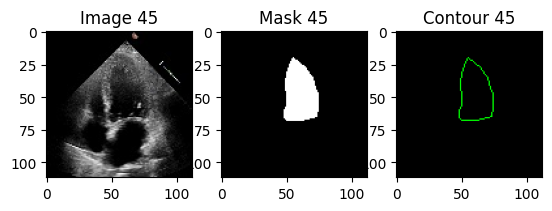

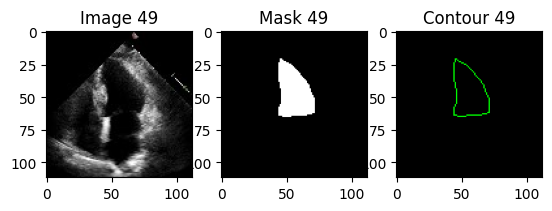

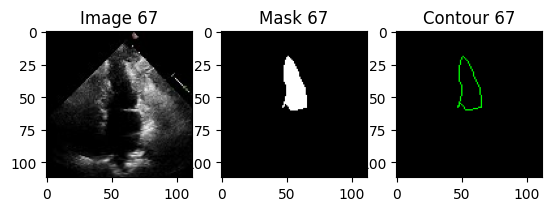

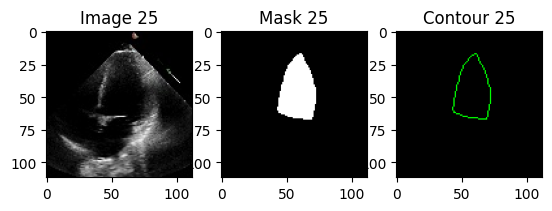

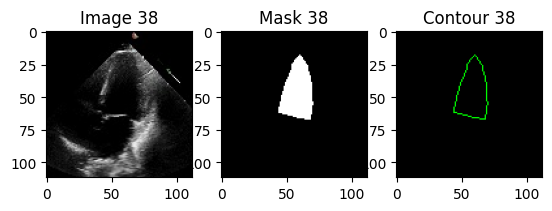

In [ ]:
image_dir = 'all_frames'
image_width, image_height = 112, 112

masks = []
images = []
contours_images = []

unique_frames = filtered_df['Frame'].unique()
for frame_number in unique_frames:
    frame_number = int(frame_number)
    filename_prefix = 'frame_'
    image_filename = f'{filename_prefix}{frame_number}.jpg'
    image_path = os.path.join(image_dir, image_filename)

    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image at {image_path}")
            continue
    except Exception as e:
        print(f"Error: {str(e)}")
        continue

    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    frame_data = filtered_df[filtered_df['Frame'] == frame_number]
    points = [(int(row['X1']), int(row['Y1'])) for _, row in frame_data.iterrows()] + [(int(row['X2']), int(row['Y2'])) for _, row in frame_data.iterrows()]
    polygon_points = refined_sort(points)
    polygon_points = np.array(polygon_points, dtype=np.int32).reshape((1, -1, 2))
    mask = cv2.fillPoly(mask, [polygon_points], (255))

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contours_image = np.zeros_like(image)
    cv2.drawContours(contours_image, contours, -1, (0, 255, 0), 1)

    masks.append(mask)
    images.append(image)
    contours_images.append(contours_image)

for i in range(len(unique_frames)):
    frame_number = unique_frames[i]
    image = images[i]
    mask = masks[i]
    contour_image = contours_images[i]

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {frame_number}')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Mask {frame_number}')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Contour {frame_number}')

    plt.show()

# Landmarks

# we use angles and curvature to calculate the last two landmarks per mask

In [ ]:
from scipy.spatial import distance


def calculate_angle(A, B, C):
    """Calculate the angle ABC given three points A, B, and C."""
    BA = np.array(A) - np.array(B)
    BC = np.array(C) - np.array(B)

    dot_product = np.dot(BA, BC)
    cross_product = np.linalg.norm(np.cross(BA, BC))

    angle = np.arctan2(cross_product, dot_product)
    return angle

def calculate_curvature(A, B, C):
   #same as before but with curvatre
    A = np.array(A, dtype=np.int32)
    B = np.array(B, dtype=np.int32)
    C = np.array(C, dtype=np.int32)

    num = (B[0] - A[0]) * (C[1] - A[1]) - (B[1] - A[1]) * (C[0] - A[0])
    den = ((B[0] - A[0])**2 + (B[1] - A[1])**2)**1.5
    if den == 0:
        return 0
    return num / den

# we calculate the first 4 landmarks by position. First the top and bottom (using their y position). Then we divide the mask and from the bottom 20% we calculate the bottom left and the bottom right

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

def extract_landmarks(polygon_points, num_landmarks=6):
    topmost_point = min(polygon_points, key=lambda p: p[1])
    bottommost_point = max(polygon_points, key=lambda p: p[1])

    sorted_by_y = sorted(polygon_points, key=lambda p: p[1], reverse=True)

    bottom_points = sorted_by_y[:int(len(sorted_by_y) * 0.2)]

    farthest_bottom_left_point = min(bottom_points, key=lambda p: p[0])
    farthest_bottom_right_point = max(bottom_points, key=lambda p: p[0])

    landmarks = [topmost_point, bottommost_point, farthest_bottom_left_point, farthest_bottom_right_point]

    curvatures = []
    angles = []
    middle_points = sorted_by_y[int(len(sorted_by_y) * 0.3):-int(len(sorted_by_y) * 0.3)]  # Middle 40%

    for i in range(len(middle_points)):
        A = middle_points[i - 1]
        B = middle_points[i]
        C = middle_points[(i + 1) % len(middle_points)]

        curvature = calculate_curvature(A, B, C)
        angle = calculate_angle(A, B, C)

        curvatures.append(curvature)
        angles.append(angle)

    combined_metric = np.abs(curvatures) * np.abs(angles)

    # Extract the top 2 points with teh most curvature and angle
    top_indices = np.argpartition(combined_metric, -2)[-2:]
    additional_landmarks = [middle_points[i] for i in top_indices]

    landmarks.extend(additional_landmarks)

    return landmarks


# we visualize the landmarks with their respective image. (we make the landmarks appear bigger for easier visualization.

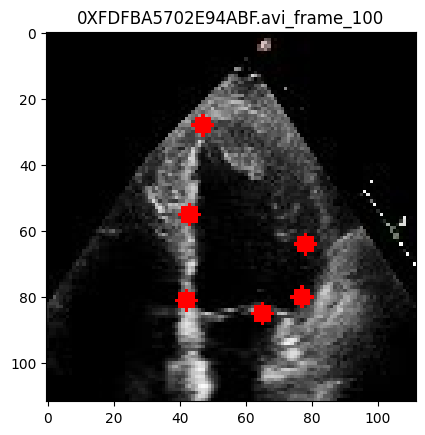

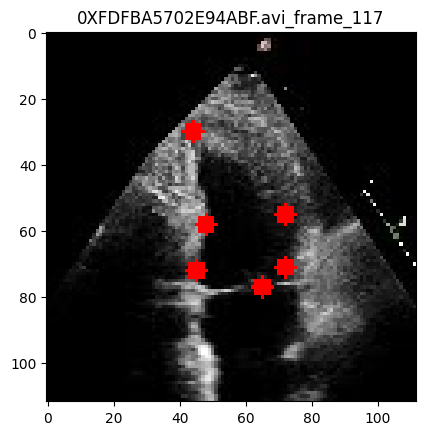

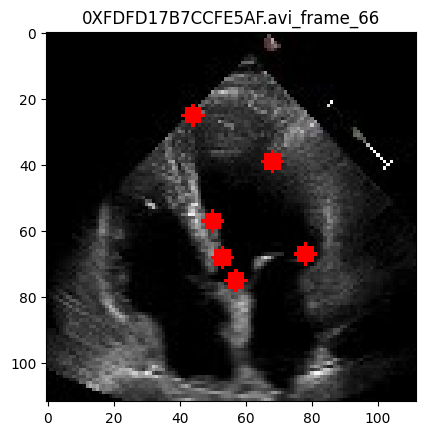

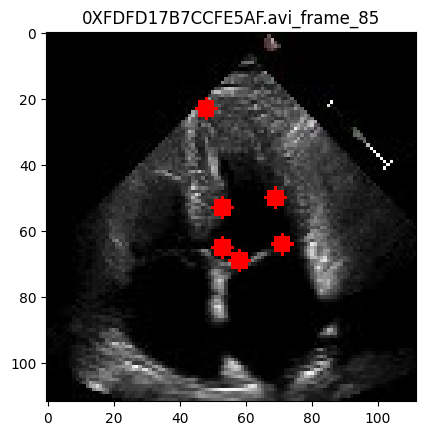

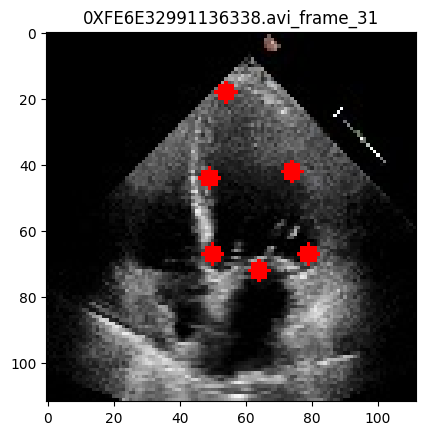

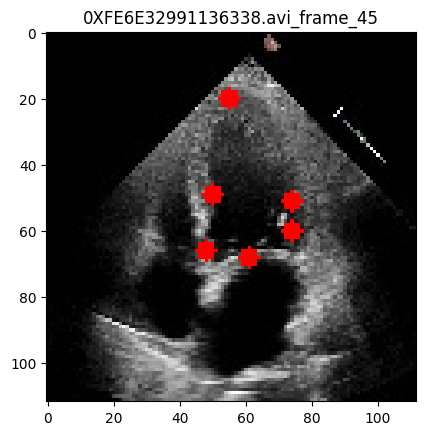

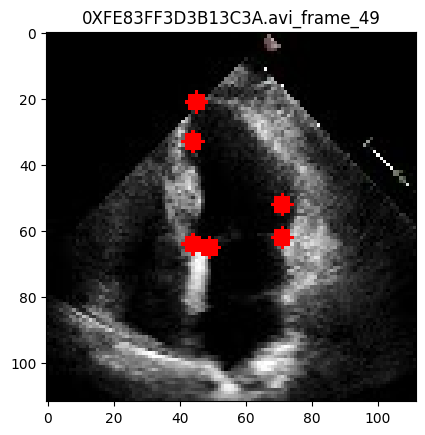

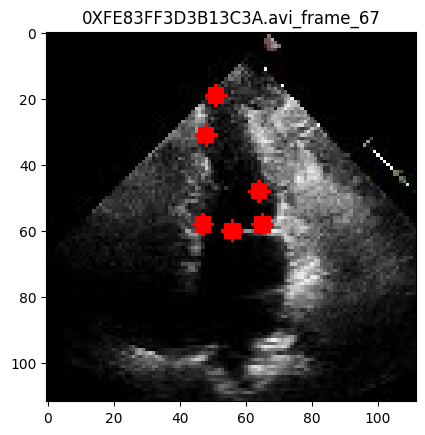

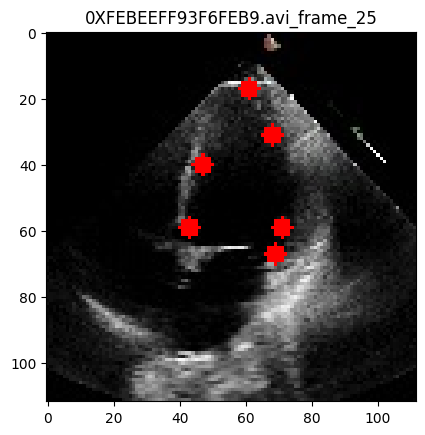

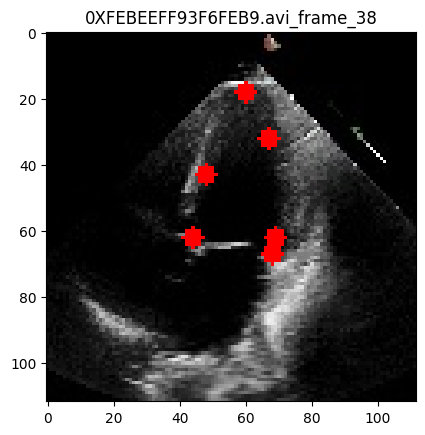

In [ ]:
landmarks_list = []
images = []
unique_combinations = filtered_df.drop_duplicates(subset=['FileName', 'Frame'])

for _, row in unique_combinations.iterrows():
    video_name = row['FileName']
    frame_number = int(row['Frame'])

    image_filename = f'frame_{frame_number}.jpg'
    image_path = os.path.join(image_dir, image_filename)

    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image at {image_path}")
            continue
        images.append(image)
    except Exception as e:
        print(f"Error: {str(e)}")
        continue

    frame_data = filtered_df[filtered_df['Frame'] == frame_number]
    points = [(int(row['X1']), int(row['Y1'])) for _, row in frame_data.iterrows()] + [(int(row['X2']), int(row['Y2'])) for _, row in frame_data.iterrows()]
    polygon_points = refined_sort(points)

    landmarks = extract_landmarks(polygon_points)

    landmarks_list.append(landmarks)

    image_copy = image.copy()
    for landmark in landmarks:
        x, y = landmark
        cv2.circle(image_copy, (x, y), radius=3, color=(0, 0, 255), thickness=-1)
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.title(f"{video_name}_frame_{frame_number}")
    plt.show()

# Creation of heatmaps

In [ ]:
import numpy as np
import scipy.ndimage

def create_gaussian_heatmap(image_shape, landmark, sigma=5):

    x = np.arange(0, image_shape[1], 1, float)
    y = np.arange(0, image_shape[0], 1, float)
    y = y[:, np.newaxis]

    heatmap = np.exp(-((x-landmark[0])**2 + (y-landmark[1])**2) / (2 * sigma**2))

    heatmap = heatmap / np.max(heatmap)

    return heatmap

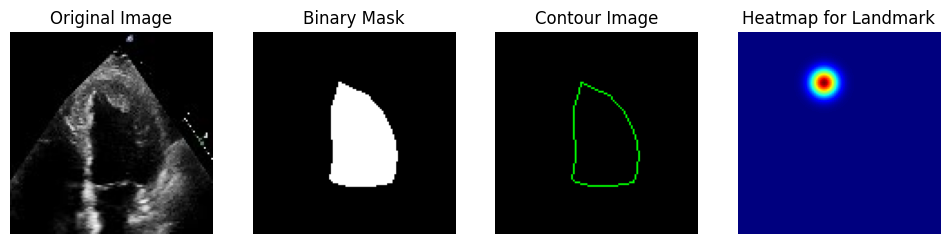

In [ ]:
heatmap = create_gaussian_heatmap(images[0].shape[:2], landmarks_list[0][0])
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(images[0])
plt.title('Original Image')
plt.axis('off')


plt.subplot(1, 4, 2)
plt.imshow(masks[0], cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(contours_images[0])
plt.title('Contour Image')
plt.axis('off')


plt.subplot(1, 4, 4)
plt.imshow(heatmap, cmap='jet')
plt.title('Heatmap for Landmark')
plt.axis('off')

plt.show()


# create contour heatmap

In [ ]:
from skimage.morphology import binary_dilation, binary_erosion, disk

def create_contour_band_from_mask(mask, disk_size):

    selem = disk(disk_size)

    dilated_mask = binary_dilation(mask, selem)
    eroded_mask = binary_erosion(mask, selem)

    contour_band = np.logical_xor(dilated_mask, eroded_mask)

    return contour_band


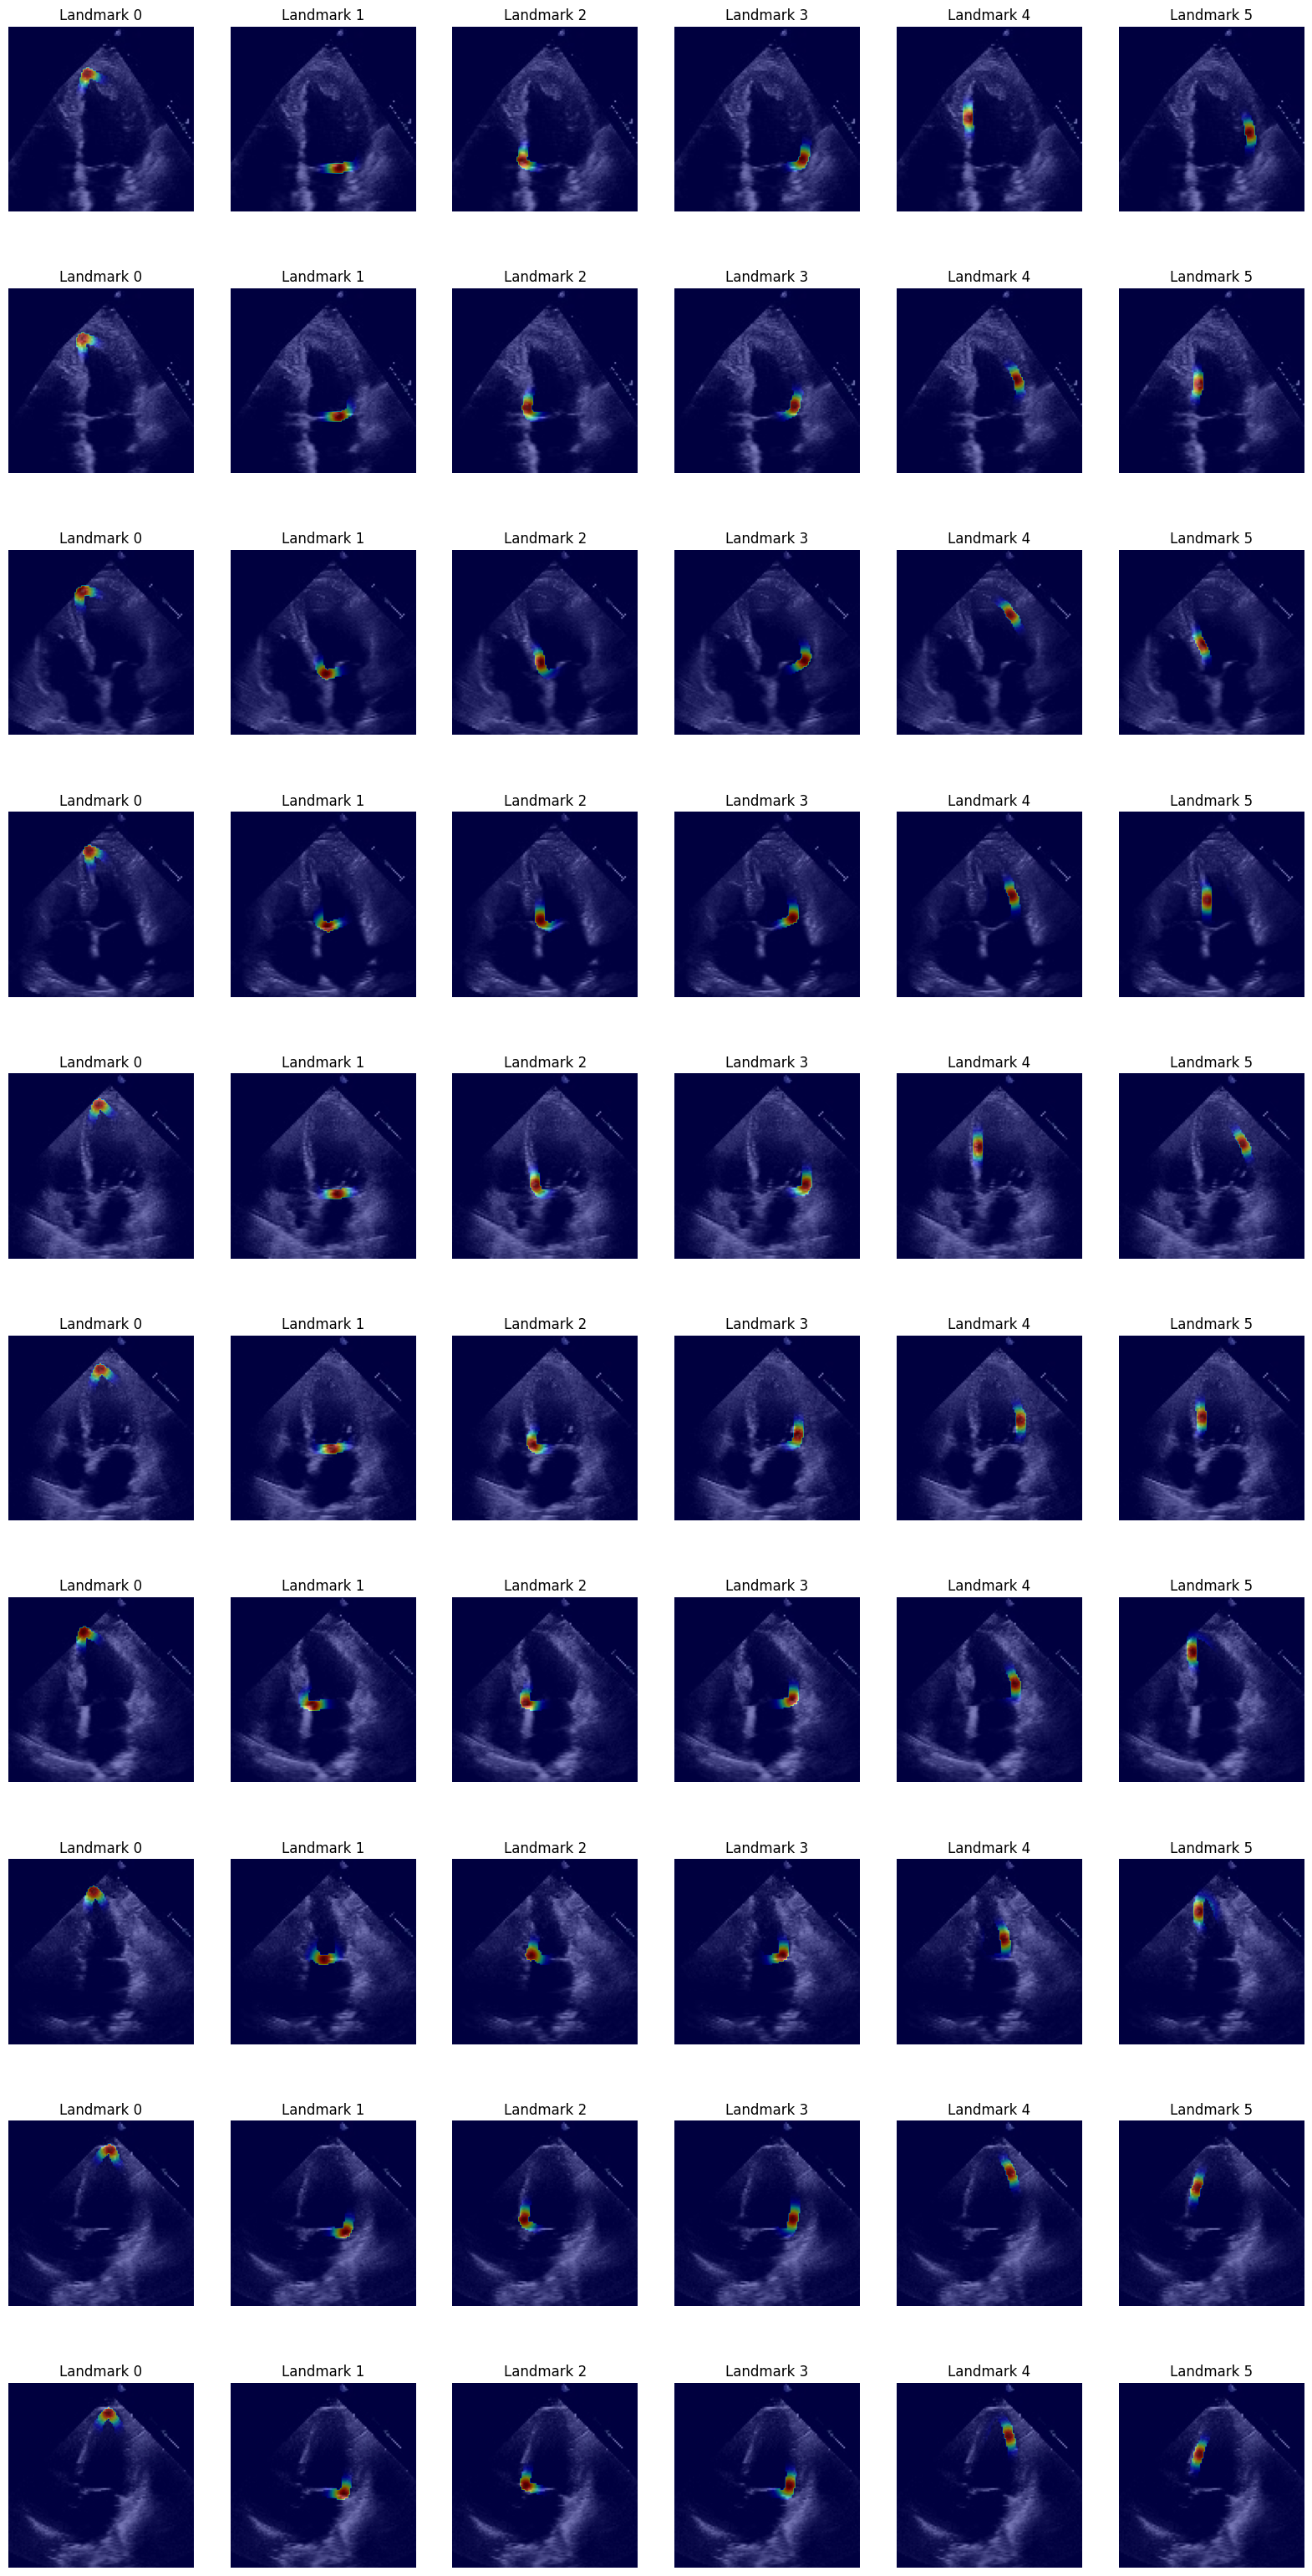

In [ ]:
num_frames_to_process = 10
plt.figure(figsize=(20, 40))

for i in range(num_frames_to_process):
    contour_band = create_contour_band_from_mask(masks[i], disk_size=3)

    for landmark in landmarks_list[i]:
        heatmap = create_gaussian_heatmap(images[i].shape[:2], landmark, sigma=5)

        heatmap_within_contour = heatmap * contour_band

        plt.subplot(num_frames_to_process, len(landmarks_list[i]), i*len(landmarks_list[i]) + landmarks_list[i].index(landmark) + 1)
        plt.imshow(images[i])
        plt.imshow(heatmap_within_contour, cmap='jet', alpha=0.5)  # Alpha for transparency
        plt.title(f'Landmark {landmarks_list[i].index(landmark)}')
        plt.axis('off')

plt.show()


# Now that we now how it works we use all the frames and we reduce the size of the heatmaps to create the final result for training the model

In [ ]:
import zipfile
import os


zip_file_path = '/content/all_frames-20231017T204430Z-001.zip'
extract_dir = '/content/extracted_framess'

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extraction completed. Frames are extracted to: {extract_dir}")


Extraction completed. Frames are extracted to: /content/extracted_framess


In [ ]:
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.morphology import binary_dilation, disk

# we download the 17.5k images we are going to use for training and we use our sort points function to get the masks, contours and landmarks.

In [ ]:
volume_tracings_path = '/content/VolumeTracings.csv'
volume_tracings_df = pd.read_csv(volume_tracings_path)

image_dir = '/content/extracted_framess/all_frames/'

images = []
masks = []
landmarks_list = []
contours_images = []

image_width, image_height = 112, 112

for frame_info, frame_df in volume_tracings_df.groupby(['FileName', 'Frame']):
    video_name, frame_number = frame_info
    image_filename = f"{video_name}_frame_{frame_number}.jpg"
    image_path = os.path.join(image_dir, image_filename)

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        continue

    points = [
        (int(row['X1']), int(row['Y1'])) for _, row in frame_df.iterrows()
    ] + [
        (int(row['X2']), int(row['Y2'])) for _, row in frame_df.iterrows()
    ]
    polygon_points = np.array(refined_sort(points), dtype=np.int32)

    if polygon_points.size == 0:
        print(f"No points found for frame {frame_number} of video {video_name}")
        continue

    try:
        landmarks = extract_landmarks(polygon_points.reshape((-1, 2)))
    except Exception as e:
        print(f"Error extracting landmarks for frame {frame_number} of video {video_name}: {e}")
        continue
    landmarks_list.append(landmarks)

    polygon_points = polygon_points.reshape((-1, 1, 2))

    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    mask = cv2.fillPoly(mask, [polygon_points], (255))
    masks.append(mask)

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = np.zeros_like(image)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 1)
    contours_images.append(contour_image)

    images.append(image)


# We save the files

In [ ]:
import numpy as np
import pickle
import os

# Save images and masks
np.save('/content/images.npy', np.array(images))
np.save('/content/masks.npy', np.array(masks))

# Save the contours images
np.save('/content/contours_images.npy', np.array(contours_images))

# Save landmarks list using pickle
with open('/content/landmarks_list.pkl', 'wb') as f:
    pickle.dump(landmarks_list, f)
from google.colab import files

files.download('/content/images.npy')
files.download('/content/masks.npy')
files.download('/content/contours_images.npy')
files.download('/content/landmarks_list.pkl')


# Now we proceed to use this files to create the heatmaps

In [ ]:
import numpy as np
import pickle
import os

images_path = '/content/drive/MyDrive/RETOECHO/images.npy'
masks_path = '/content/drive/MyDrive/RETOECHO/masks.npy'
landmarks_list_path = '/content/landmarks_list (1).pkl'

# Load the images and masks
images = np.load(images_path)
masks = np.load(masks_path)

# Load the landmarks list
with open(landmarks_list_path, 'rb') as f:
    landmarks_list = pickle.load(f)


In [ ]:
def create_gaussian_heatmap(image_shape, landmark, sigma=3, is_key_landmark=True):

    x = np.arange(0, image_shape[1], 1, float)
    y = np.arange(0, image_shape[0], 1, float)
    y = y[:, np.newaxis]

    heatmap = np.exp(-((x-landmark[0])**2 + (y-landmark[1])**2) / (2 * sigma**2))

    heatmap = heatmap / np.max(heatmap)

    return heatmap

In [ ]:
import numpy as np
from skimage.morphology import square
from skimage.morphology import binary_dilation, binary_erosion, disk

def create_contour_band_from_mask(mask, kernel_size):

    selem = square(kernel_size)

    dilated_mask = binary_dilation(mask, selem)
    eroded_mask = binary_erosion(mask, selem)

    contour_band = np.logical_xor(dilated_mask, eroded_mask)

    return contour_band.astype(np.uint8)


# we create the heatmaps. 6 for each image

In [ ]:
import numpy as np
import cv2

kernel_size = 3

all_heatmapss = []

for i in range(min(len(images), 2000)):
    image = images[i]
    mask = masks[i]
    landmarks = landmarks_list[i]

    contour_band = create_contour_band_from_mask(mask, kernel_size)

    image_heatmaps = []

    for landmark in landmarks_list[i]:
        heatmap = create_gaussian_heatmap(images[i].shape[:2], landmark, sigma=5)

        heatmap_within_contour = heatmap * contour_band
        image_heatmaps.append(heatmap_within_contour)

    all_heatmapss.append(image_heatmaps)

In [ ]:
all_heatmapss_array = np.array(all_heatmapss)

np.save('EQUALheatmaps.npy', all_heatmapss_array)

# we save the heatmps in google drive

In [ ]:
from google.colab import files
files.download('EQUALheatmaps.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# we visualize a random image with its heatmaps to analyze the results

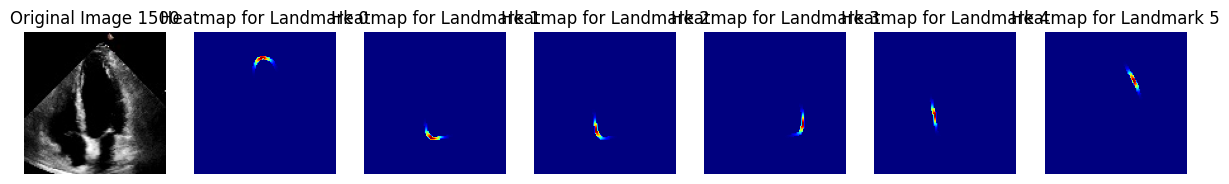

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

random_index = 1500
selected_image = images[random_index]
selected_heatmaps = all_heatmapss[random_index]

plt.figure(figsize=(15, 10))

plt.subplot(1, len(selected_heatmaps) + 1, 1)
plt.imshow(cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB))
plt.title(f'Original Image {random_index}')
plt.axis('off')

for i, heatmap in enumerate(selected_heatmaps):
    plt.subplot(1, len(selected_heatmaps) + 1, i + 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title(f'Heatmap for Landmark {i}')
    plt.axis('off')

plt.show()
